In [1]:
import cv2
import dlib
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from torchvision import transforms
import torchvision
import matplotlib.pyplot as plt 
import numpy as np
from PIL import Image, ImageOps
from sklearn.metrics import confusion_matrix
import itertools
from copy import copy
import time

In [2]:
class MRLDataset(torch.utils.data.Dataset):
    def __init__(self, path):
        self.transforms = transforms.Compose([transforms.ToTensor()]) 
        self.img_classes = [ 'Closed','Open']
        self.img_paths = []
        self.img_labels = []

        # Traverses all subfolders and stores the path and label of each training example
        subfolders = os.listdir(path)
        for folder in subfolders:
            p = os.path.join(path, folder)

            if os.path.isdir(p):                                                    # ignores documentation files
                imgs = os.listdir(p)

                for file_name in imgs:
                    self.img_paths.append(os.path.join(p, file_name))               # append image path
                    self.img_labels.append(int(file_name.split("_")[4]))            # append eye state label
    
    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = Image.open(self.img_paths[idx]).convert("L")
        img = ImageOps.equalize(img)
        img = self.transforms(img)

        label = self.img_labels[idx]

        return (img, label)


In [3]:
class EyeClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.fc1 = nn.Linear(6*6*32, 256)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 6*6*32)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [4]:
# Evaluates accuracy (and loss) based for DataLoader
def evaluate(model, loader, criterion = None):
    total_losses = 0
    total_correct = 0
    total_examples = 0

    for i, [inputs, labels] in enumerate(loader):
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()

        outputs = model(inputs)
        
        # Track total loss
        if criterion:
            loss = criterion(outputs, labels)
            total_losses += loss.item()

        # Track total correct
        pred = outputs.argmax(dim = 1)
        total_correct += pred.eq(labels).sum().item()
        total_examples += inputs.shape[0]

    if criterion:
        return total_losses/(i+1), total_correct/total_examples 
    else:
        return total_correct/total_examples

# Predicts output based on a single 1x24x24 image tensor
def predict(model, img):
    outputs = model(img.unsqueeze(0))
    prob = F.softmax(outputs, dim = 1)
    pred = outputs.argmax(dim = 1).item()

    print(f"Probabilities: ({prob[0][0]}, {prob[0][1]})")
    print("Prediction:", pred)

In [5]:
def train(model, train_loader, valid_loader, learning_rate = 0.001, num_epochs = 10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    print('Loading Data...')
    iters, train_losses, valid_losses, train_acc, valid_acc = [], [], [], [], []

    t = time.time()

    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()

            outputs = model(inputs)                     # forward pass

            loss = criterion(outputs, labels)           # calculate loss
            loss.backward()                             # calculate gradients using backprop
            optimizer.step()                            # apply optimizer step
            optimizer.zero_grad()                       # zero the gradients

        # Calculate and record loss/accuracy values
        [l, a] = evaluate(model, train_loader, criterion)
        train_losses.append(l)
        train_acc.append(a)

        [l, a] = evaluate(model, valid_loader, criterion)
        valid_losses.append(l)
        valid_acc.append(a)

        iters.append(epoch)

        print("Epoch:", epoch+1, "Time Taken:", time.time() - t)
        t = time.time()

        
    # Plot training curves
    plt.title("Training Curve - Loss")
    plt.plot(iters, train_losses, label = "Training")
    plt.plot(iters, valid_losses, label = "Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Loss: {}".format(train_losses[-1]))
    print("Final Validation Loss: {}".format(valid_losses[-1]))
    print()

    plt.title("Training Curve - Accuracy")
    plt.plot(iters, train_acc, label = "Training")
    plt.plot(iters, valid_acc, label = "Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(valid_acc[-1]))

In [8]:
# Create Dataset object
dataset = MRLDataset(r'C:\Users\alast\OneDrive\Desktop\driver_drowsiness\MRL')       # Pass in root folder of dataset

# Random split (60-20-20)
n = len(dataset)
n_train = int(0.7 *n)
n_valid = int(0.15 *n)
n_test = n - n_train - n_valid

[train_set, valid_set, test_set] = torch.utils.data.random_split(dataset, [n_train, n_valid, n_test])

#apply Data Augmentation to training set
aug_train_set = []
t = transforms.Compose([
    torchvision.transforms.GaussianBlur(3),
    torchvision.transforms.RandomRotation(30),
    torchvision.transforms.RandomHorizontalFlip(p = .25),
    torchvision.transforms.RandomResizedCrop((32, 32), scale = (0.8, 1.0))])
for i in range(10):
    print(len(aug_train_set))
    for item in train_set:
       
        aug_train_set.append((t(item[0]),item[1]))


#train_setFIN=torch.cat(train_set, train_setAUG)
t_valtest= transforms.Compose( [transforms.Resize([32,32])])
valid_set.dataset.transforms=t_valtest
test_set.dataset.transforms =t_valtest


# Create DataLoaders
batch_size = 64
num_workers = 0
train_loader = torch.utils.data.DataLoader(aug_train_set, batch_size = batch_size, shuffle = True, num_workers = num_workers)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size = batch_size, shuffle = True, num_workers = num_workers)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = True, num_workers = num_workers)

'\n# Create DataLoaders\nbatch_size = 64\nnum_workers = 0\ntrain_loader = torch.utils.data.DataLoader(aug_train_set, batch_size = batch_size, shuffle = True, num_workers = num_workers)\nvalid_loader = torch.utils.data.DataLoader(val_set_load, batch_size = batch_size, shuffle = True, num_workers = num_workers)\ntest_loader = torch.utils.data.DataLoader(test_set_load, batch_size = batch_size, shuffle = True, num_workers = num_workers)'

Loading Data...
Epoch: 1 Time Taken: 32.85711860656738
Epoch: 2 Time Taken: 28.39642024040222
Epoch: 3 Time Taken: 28.447934865951538
Epoch: 4 Time Taken: 28.568962812423706
Epoch: 5 Time Taken: 28.734496116638184
Epoch: 6 Time Taken: 28.343408584594727
Epoch: 7 Time Taken: 28.358410358428955
Epoch: 8 Time Taken: 28.31940269470215
Epoch: 9 Time Taken: 28.324403762817383
Epoch: 10 Time Taken: 28.26838994026184
Epoch: 11 Time Taken: 28.33040475845337
Epoch: 12 Time Taken: 28.3073992729187
Epoch: 13 Time Taken: 28.4974422454834
Epoch: 14 Time Taken: 28.765007734298706
Epoch: 15 Time Taken: 28.331404447555542
Epoch: 16 Time Taken: 28.395925283432007
Epoch: 17 Time Taken: 28.408423900604248
Epoch: 18 Time Taken: 28.335405349731445
Epoch: 19 Time Taken: 28.334909200668335
Epoch: 20 Time Taken: 28.32682466506958


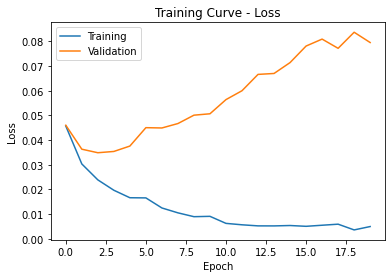

Final Training Loss: 0.004943563691485261
Final Validation Loss: 0.07957650195621142



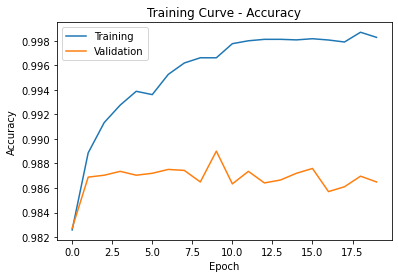

Final Training Accuracy: 0.9982819546341791
Final Validation Accuracy: 0.9864928537772891


In [24]:
model_DataAug2=EyeClassifier()
model_DataAug2.cuda()

train(model_DataAug2, train_loader, valid_loader, learning_rate = 0.001, num_epochs = 20)

In [26]:
evaluate(model_DataAug2, test_loader)

0.9864928537772891

In [29]:
'''torch.save(model_DataAug2.state_dict(), r'C:\Users\alast\OneDrive\Desktop\driver_drowsiness\driver-drowsiness-detection-main\Saved Models\model_DataAug2.pt')


Epoch: 0 Time Taken: 72.12334275245667
Epoch: 1 Time Taken: 68.28418207168579
Epoch: 2 Time Taken: 68.00483918190002
Epoch: 3 Time Taken: 67.09201955795288
Epoch: 4 Time Taken: 71.38202738761902
Epoch: 5 Time Taken: 73.25348091125488
Epoch: 6 Time Taken: 67.48882460594177
Epoch: 7 Time Taken: 70.28859043121338
Epoch: 8 Time Taken: 67.43788456916809
Epoch: 9 Time Taken: 68.95002460479736
Epoch: 10 Time Taken: 70.48782444000244
Epoch: 11 Time Taken: 70.1263656616211
Epoch: 12 Time Taken: 69.34038925170898
Epoch: 13 Time Taken: 68.26120162010193
Epoch: 14 Time Taken: 65.64543795585632
Epoch: 15 Time Taken: 65.63101816177368
Epoch: 16 Time Taken: 67.42552328109741
Epoch: 17 Time Taken: 67.50480794906616
Epoch: 18 Time Taken: 68.88110017776489
Epoch: 19 Time Taken: 69.63994693756104


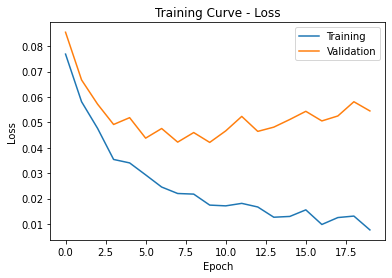

Final Training Loss: 0.007649422601009134
Final Validation Loss: 0.05449162497752815



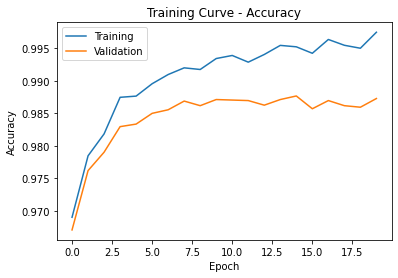

Final Training Accuracy: 0.9974591101837518
Final Validation Accuracy: 0.987278152976284


In [7]:
model = EyeClassifier()

train(model, train_loader, valid_loader, learning_rate = 0.001, num_epochs = 20)

In [8]:
'torch.save(model.state_dict(), "./Saved Models/model3.pt")

In [7]:
model = EyeClassifier()
model.load_state_dict(torch.load("./Saved Models/model2.pt"))
model.eval()

EyeClassifier(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)

In [9]:
evaluate(model, test_loader)

0.987751256281407

In [ ]:
# Make predictions for all images within "Frames" folder

t = transforms.Compose([transforms.Resize([24, 24]), transforms.Grayscale(), transforms.ToTensor()]) 
frames_path = "./Frames"

for i, file_name in enumerate(os.listdir(frames_path)):
    img = Image.open(os.path.join(frames_path, file_name))
    img = t(img)

    print(f"\n{i}.jpg")
    predict(model, img)


In [19]:
img = Image.open(os.path.join(frames_path, "216.jpg"))
img = t(img)

predict(model, img)

Probabilities: (0.999854564666748, 0.00014536091475747526)
Prediction: 0


**Below is Code for the Confusion Matrix**

In [35]:
# Load CNN eye classifier
eye_model = EyeClassifier()
#eye_model = ANNClassifier()
eye_model.load_state_dict(torch.load(r"C:\Users\alast\OneDrive\Desktop\driver_drowsiness\driver-drowsiness-detection-main\Saved Models\model_eqtest.pt"))
eye_model.eval()

EyeClassifier(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)

In [78]:
def get_predict(model, loader, use_cuda=True):
    ''' Concatenates predictions and labels into tensors
        to be used in confusion matrix
        (model, loader) -> (tensor, tensor)'''
    
    preds = torch.tensor([])
    labels = torch.tensor([])
    for image, label in loader:


        
            
        outputs = model(image)
        pred= outputs.argmax(dim=1)
        
        preds = torch.cat(
            (preds, pred), dim=0
        )
        
        
        
        labels = torch.cat(
            (labels,label), dim=0
        )
    return preds, labels


def get_correct(preds, labels):
    ''' calculates how many predictions are 
        correct.
        (preds, labels) -> (tensor)'''
    
    

    #calculates index of maximum values in each prediction tensor
    #then equates prediction tensor to label tensor (T or F)
    #then sums the total correct predictions and returns the total as an int

    correct = preds.eq(labels).sum().item()
    return correct





In [33]:
#copied cause i didn't wanna make everyone have to import
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[6312   33]
 [  58 6331]]


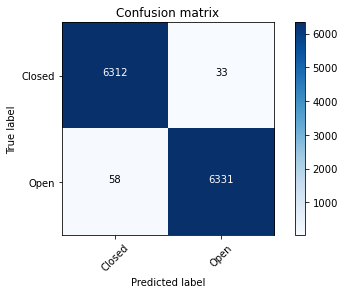

In [84]:
#Getting Predictions from model as tensor
preds , labels = get_predict(eye_model, valid_loader)
#Getting labels as tensor

c_matrix = confusion_matrix(labels, preds)

plot_confusion_matrix(c_matrix, ['Closed', 'Open'])


